<a href="https://colab.research.google.com/github/ptnv-s/Knee-Abnormality-and-Common-Disorders/blob/colab/VGG16_MRNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Based Musculoskeletal Diagnosis, Abnormality and Common Disorders detection using Knee Magnetic Resonance Imaging

---

Magnetic resonance (MR) imaging of the knee is the standard of care imaging modality to evaluate knee disorders, and more musculoskeletal MR examinations are performed on the knee than on any other region of the body.

---

We will be implementing deep learning baselines for detecting general abnormalities and specific diagnoses (anterior cruciate ligament [ACL] tears and meniscal tears) on knee MRI exams.

---

The most common indications for the knee MRI examinations in this study included acute and chronic pain, follow-up or preoperative evaluation, injury/trauma.

---
We have used the [MRNet dataset](https://stanfordmlgroup.github.io/competitions/mrnet/)  which consists of 1,370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams, with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears. The labels were obtained through manual extraction from clinical reports.

---

Examinations were performed with GE scanners (GE Discovery, GE Healthcare, Waukesha, WI) with standard knee MRI coil and a routine non-contrast knee MRI protocol that included the following sequences: coronal T1 weighted, coronal T2 with fat saturation, sagittal proton density (PD) weighted, sagittal T2 with fat saturation, and axial PD weighted with fat saturation. A total of 775 (56.6%) examinations used a 3.0-T magnetic field the remaining used a 1.5-T magnetic field as reported [here](https://stanfordmlgroup.github.io/projects/mrnet/) .

For more details refer to the paper related to this study [here](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002699).

---

Given a MRI scan our deep learning model will be predicting 3 outcomes for knee MRI exams (anterior cruciate ligament [ACL] tears, meniscal tears, and general abnormalities).

#### Importing Basic Libraries

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import math

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras import backend as K
from keras.layers import Input

##### Defining Custom Metric for Evaluation

In [ ]:
import keras.backend as K

def f1_score(y_true, y_pred):
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))
    if c3 == 0.0 :
        return 0.0
    precision = c1 / c2
    recall = c1 / c3
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score
  

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##Loading Files for loading Different Planes of Scans of Dataset
As we know from EDA Notebook this dataset has 3 views of Knee since datset has MRI scans namely -

*   Axial
*   Coronal
*   Sagittal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
with open("/content/drive/MyDrive/Medical/MRNet-v1.0/train-abnormal.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainAb_labels=[]
    for row in csv_reader:
           trainAb_labels.append(int(row[1]))
print(trainAb_labels)
trainAb_labels= np.array(trainAb_labels)
print(len(trainAb_labels))

with open("/content/drive/MyDrive/Medical/MRNet-v1.0/train-acl.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainACL_labels=[]
    for row in csv_reader:
           trainACL_labels.append(int(row[1]))
print(trainAb_labels)
trainACL_labels= np.array(trainACL_labels)
print(len(trainACL_labels))


with open("/content/drive/MyDrive/Medical/MRNet-v1.0/train-meniscus.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainMen_labels=[]
    for row in csv_reader:
           trainMen_labels.append(int(row[1]))
print(trainMen_labels)
trainAb_labels= np.array(trainMen_labels)
print(len(trainMen_labels))

with open("/content/drive/MyDrive/Medical/MRNet-v1.0/valid-abnormal.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testAb_labels=[]
    for row in csv_reader:
           testAb_labels.append(int(row[1]))
print(testAb_labels)
testAb_labels= np.array(testAb_labels)
print(len(testAb_labels))

with open("/content/drive/MyDrive/Medical/MRNet-v1.0/valid-acl.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testACL_labels=[]
    for row in csv_reader:
           testACL_labels.append(int(row[1]))
print(testACL_labels)
testACL_labels= np.array(testACL_labels)
print(len(testACL_labels))


with open("/content/drive/MyDrive/Medical/MRNet-v1.0/valid-meniscus.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testMen_labels=[]
    for row in csv_reader:
           testMen_labels.append(int(row[1]))
print(testMen_labels)
testMen_labels= np.array(testMen_labels)
print(len(testMen_labels))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
train_Ab_pred = []
test_Ab_pred = []
train_Men_pred = []
test_Men_pred = []
train_ACL_pred = []
test_ACL_pred = []

##AxialPlane Scans

###Reading train & test data

In [ ]:

axial_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/train/axial/")
axial_dir = [f.lower() for f in axial_dir]   
a=sorted(axial_dir)
axial_list=np.array(a)
axial_reloaded=[]

print(axial_list.shape)
for j in range(1,1131):
    file= "/content/drive/MyDrive/Medical/MRNet-v1.0/train/axial/"+axial_list[j]    
    axial_reloaded.append(np.load(file,allow_pickle='false'))   

axial_reloaded=np.array(axial_reloaded)

print(axial_reloaded.shape)
s=axial_reloaded.shape
print(axial_reloaded[0].shape[0])

train_axial=[]

print(len(axial_reloaded))

for j in range(len(axial_reloaded)):
    mid=math.floor((axial_reloaded[j].shape[0])/2)
    train_axial.append([])    

    for n in range(mid-1,mid+2):
         train_axial[j].append(axial_reloaded[j][n])
train_axial=np.array(train_axial)
train_axial=np.reshape(train_axial,(1130,256,256,3))
print(train_axial.shape)

axial_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/valid/axial/")
axial_dir = [f.lower() for f in axial_dir]   
a=sorted(axial_dir)
axialTest_list=np.array(a)
axialTest_reloaded=[]

print(axialTest_list.shape)

for j in range(0,120):
    file= "/content/drive/MyDrive/Medical/MRNet-v1.0/valid/axial/"+axialTest_list[j]
    axialTest_reloaded.append(np.load(file,allow_pickle='false'))   

axialTest_reloaded=np.array(axialTest_reloaded)

print(axialTest_reloaded.shape)

s=axialTest_reloaded.shape
print(axialTest_reloaded[0].shape[0])

test_axial=[]

print(len(axialTest_reloaded))

for j in range(len(axialTest_reloaded)):
    mid=math.floor((axialTest_reloaded[j].shape[0])/2)
    test_axial.append([])    

    for n in range(mid-1,mid+2):
         test_axial[j].append(axialTest_reloaded[j][n])
test_axial=np.array(test_axial)
test_axial=np.reshape(test_axial,(120,256,256,3))
print(test_axial.shape)

(1131,)


#### Finetuning ResNet50 Model for Axial Plane Scanes checking for Meniscus Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_ax_men = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
print(len(base_model_ax_men.layers))

58900480/58889256 [==============================] - 0s 0us/step
19


In [ ]:
x = base_model_ax_men.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model_ax_men.input,outputs=predictions)

In [ ]:
for layer in model.layers[:15]:
   layer.trainable = True
for layer in model.layers[15:]:
  layer.trainable = False

In [ ]:
trainMen_labels = np.array(trainMen_labels)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy', f1_score])
history=model.fit(train_axial ,trainMen_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 16)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
68/68 [==============================] - 59s 613ms/step - loss: 0.8385 - accuracy: 0.5862 - f1_score: nan - val_loss: 0.6708 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 2/100
68/68 [==============================] - 38s 554ms/step - loss: 0.6576 - accuracy: 0.6291 - f1_score: nan - val_loss: 0.6608 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 3/100
68/68 [==============================] - 38s 555ms/step - loss: 0.6471 - accuracy: 0.6459 - f1_score: nan - val_loss: 0.6453 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 4/100
68/68 [==============================] - 38s 554ms/step - loss: 0.6380 - accuracy: 0.6486 - f1_score: nan - val_loss: 0.6354 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 5/100
68/68 [==============================] - 38s 552ms/step - loss: 0.6272 - accuracy: 0.6524 - f1_score: nan - val_loss: 0.6293 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 6/100
68/68 [==============================] - 37s 551ms/step - loss: 0.6239 - accuracy: 0.658

####Plotting accuracy of both training and validation sets per epoch.

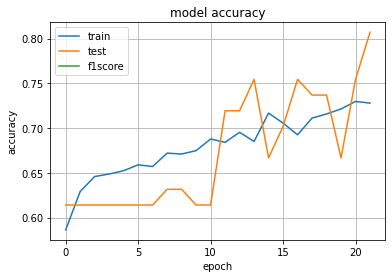

In [ ]:
p = np.array(model.predict(train_axial))
train_Men_pred.append(p)
p = np.array(model.predict(test_axial))
test_Men_pred.append(p)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'f1score'], loc='upper left')
plt.grid() 
plt.show()

##### Helper function to clear Memory Utilization enabling it to Work in Colab with K80 GPU and standard RAM allowance.

In [ ]:
import gc
def clean_up(model):
    K.clear_session()
    del model
    gc.collect() #garbage collection
    print("...Finished clean up...")

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/modelvgg1.h5'
model.save(filename)
print('>Saved %s' % filename)
clean_up(model=model)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/modelvgg1.h5
...Finished clean up...


#### Finetuning VGG16 Model for Axial Plane Scanes checking for ACL Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_ax_ACL = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_ax_ACL.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs=base_model_ax_ACL.input,outputs=predictions)

In [ ]:
for layer in model2.layers[:15]:
   layer.trainable = True
for layer in model2.layers[15:]:
  layer.trainable = False

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model2.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history2=model2.fit(train_axial ,trainACL_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 61s 990ms/step - loss: 0.6492 - accuracy: 0.7558 - f1_score: nan - val_loss: 0.4591 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 46s 845ms/step - loss: 0.5229 - accuracy: 0.7968 - f1_score: nan - val_loss: 0.4350 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 46s 844ms/step - loss: 0.4963 - accuracy: 0.8024 - f1_score: nan - val_loss: 0.4253 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 46s 844ms/step - loss: 0.4985 - accuracy: 0.8080 - f1_score: nan - val_loss: 0.4436 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 46s 843ms/step - loss: 0.4861 - accuracy: 0.8136 - f1_score: nan - val_loss: 0.3998 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 46s 844ms/step - loss: 0.4665 - accuracy: 0.8089 - f1_score

4/4 [==============================] - 1s 359ms/step - loss: 1.0762 - accuracy: 0.7083 - f1_score: 0.3989
Train loss: 1.0762392282485962
Train accuracy: 0.7083333134651184


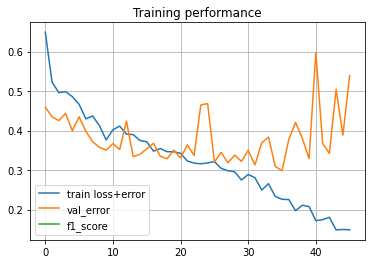

In [ ]:
p = np.array(model2.predict(train_axial))
train_ACL_pred.append(p)
p = np.array(model2.predict(test_axial))
test_ACL_pred.append(p)                    
score2 = model2.evaluate(test_axial ,testACL_labels,verbose=1)       
print('Train loss:',score2[0])
print('Train accuracy:',score2[1])                                                                
plt.figure()
plt.grid()                                                                                                     
plt.title('Training performance')                          
plt.plot(history2.epoch, history2.history['loss'], label='train loss+error')  
plt.plot(history2.epoch, history2.history['val_loss'], label='val_error')
plt.plot(history2.epoch, history2.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/modelVGG162.h5'
model2.save(filename)
print('>Saved %s' % filename)
clean_up(model=model2)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/modelVGG162.h5
...Finished clean up...


#### Finetuning ResNet50 Model for Axial Plane Scanes checking for Abnormal Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_ax_AB = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_ax_AB.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model3 = Model(inputs=base_model_ax_AB.input,outputs=predictions)

In [ ]:
for layer in model3.layers[:15]:
   layer.trainable = True
for layer in model3.layers[15:]:
  layer.trainable = False

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model3.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history3=model3.fit(train_axial ,trainAb_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 47s 851ms/step - loss: 0.7498 - accuracy: 0.6263 - f1_score: nan - val_loss: 0.6541 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 46s 845ms/step - loss: 0.6590 - accuracy: 0.6431 - f1_score: nan - val_loss: 0.6634 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 46s 846ms/step - loss: 0.6576 - accuracy: 0.6403 - f1_score: nan - val_loss: 0.6436 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 46s 845ms/step - loss: 0.6451 - accuracy: 0.6440 - f1_score: nan - val_loss: 0.6288 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 46s 846ms/step - loss: 0.6095 - accuracy: 0.6608 - f1_score: nan - val_loss: 0.6033 - val_accuracy: 0.6316 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 46s 845ms/step - loss: 0.6121 - accuracy: 0.6570 - f1_score

4/4 [==============================] - 1s 359ms/step - loss: 0.7807 - accuracy: 0.6167 - f1_score: 0.6199
Test loss: 0.7807239294052124
Test accuracy: 0.6166666746139526


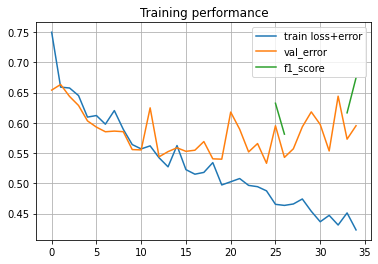

In [ ]:
p = np.array(model3.predict(train_axial))
train_Ab_pred.append(p)
p = np.array(model3.predict(test_axial))
test_Ab_pred.append(p)               
score3 = model3.evaluate(test_axial ,testAb_labels,verbose=1)       
print('Test loss:',score3[0])
print('Test accuracy:',score3[1])                                                           
plt.figure()
plt.grid()                                                                                                  
plt.title('Training performance')                          
plt.plot(history3.epoch, history3.history['loss'], label='train loss+error')  
plt.plot(history3.epoch, history3.history['val_loss'], label='val_error') 
plt.plot(history3.epoch, history3.history['f1_score'], label='f1_score') 
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel3.h5'
model3.save(filename)
print('>Saved %s' % filename)
clean_up(model=model3)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel3.h5
...Finished clean up...


##### Deleting Files which wont be required further to reduce memory load

In [ ]:
del train_axial
del test_axial
del axial_dir
del axial_reloaded
del axialTest_reloaded
del axial_list
del axialTest_list
del model
del model2
del model3
del base_model_ax_men
del base_model_ax_ACL
del base_model_ax_AB
del p

##Coronal Plane Scans

###Reading train & test data

In [ ]:
coronal_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/train/coronal/")
coronal_dir = [f.lower() for f in coronal_dir]   
c=sorted(coronal_dir)
coronal_list=np.array(c)
coronal_reloaded=[]
print(coronal_list.shape)
for j in range(1,1131):
    file2= "/content/drive/MyDrive/Medical/MRNet-v1.0/train/coronal/"+coronal_list[j]
    coronal_reloaded.append(np.load(file2,allow_pickle='false'))

coronal_reloaded=np.array(coronal_reloaded)
print(coronal_reloaded.shape)
train_coronal=[]
 
for j in range(len(coronal_reloaded)):
    mid2=math.floor((coronal_reloaded[j].shape[0])/2)
    train_coronal.append([])
        
    for n in range(mid2-1,mid2+2):
         train_coronal[j].append(coronal_reloaded[j][n])

train_coronal=np.array(train_coronal)
train_coronal=np.reshape(train_coronal,(1130,256,256,3))
print(train_coronal.shape)

coronal_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/valid/coronal/")
coronal_dir = [f.lower() for f in coronal_dir]   
c=sorted(coronal_dir)
coronalTest_list=np.array(c)
coronalTest_reloaded=[]
print(coronalTest_list.shape)
for j in range(0,120):
    file2= "/content/drive/MyDrive/Medical/MRNet-v1.0/valid/coronal/"+coronalTest_list[j]
    coronalTest_reloaded.append(np.load(file2,allow_pickle='false'))

coronalTest_reloaded=np.array(coronalTest_reloaded)
print(coronalTest_reloaded.shape)
test_coronal=[]
 
for j in range(len(coronalTest_reloaded)):
    mid2=math.floor((coronalTest_reloaded[j].shape[0])/2)
    test_coronal.append([])
        
    for n in range(mid2-1,mid2+2):
         test_coronal[j].append(coronalTest_reloaded[j][n])

test_coronal=np.array(test_coronal)
test_coronal=np.reshape(test_coronal,(120,256,256,3))
print(test_coronal.shape)

(1131,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


(1130,)
(1130, 256, 256, 3)
(120,)
(120,)
(120, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### Finetuning VGG16 Model for Coronal Plane Scanes checking for Meniscus Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Co_Men = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_Co_Men.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model4 = Model(inputs=base_model_Co_Men.input,outputs=predictions)

In [ ]:
for layer in model4.layers[:15]:
   layer.trainable = True
for layer in model4.layers[15:]:
  layer.trainable = False

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)    
model4.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history4=model4.fit(train_coronal ,trainMen_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
54/54 [==============================] - 48s 855ms/step - loss: 0.9005 - accuracy: 0.5461 - f1_score: nan - val_loss: 0.6736 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 46s 843ms/step - loss: 0.6630 - accuracy: 0.6067 - f1_score: nan - val_loss: 0.6661 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 45s 842ms/step - loss: 0.6666 - accuracy: 0.6337 - f1_score: nan - val_loss: 0.6613 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 45s 842ms/step - loss: 0.6562 - accuracy: 0.6449 - f1_score: nan - val_loss: 0.6510 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 45s 842ms/step - loss: 0.6405 - accuracy: 0.6347 - f1_score: nan - val_loss: 0.6559 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 45s 841ms/step - loss: 0.6465 - accuracy: 0.645

4/4 [==============================] - 1s 359ms/step - loss: 0.6888 - accuracy: 0.5667 - f1_score: nan
Test loss: 0.6887705326080322
Test accuracy: 0.5666666626930237


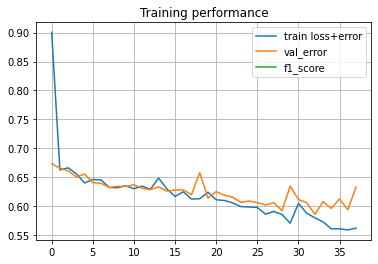

In [ ]:
p = np.array(model4.predict(train_coronal))
train_Men_pred.append(p)
p = np.array(model4.predict(test_coronal))
test_Men_pred.append(p)
score4 = model4.evaluate(test_coronal ,testMen_labels,verbose=1)       
print('Test loss:',score4[0])
print('Test accuracy:',score4[1])                                              
plt.figure()
plt.grid()                                                                                                   
plt.title('Training performance')                          
plt.plot(history4.epoch, history4.history['loss'], label='train loss+error')  
plt.plot(history4.epoch, history4.history['val_loss'], label='val_error')  
plt.plot(history4.epoch, history4.history['f1_score'], label='f1_score')  
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel4.h5'
model4.save(filename)
print('>Saved %s' % filename)
clean_up(model=model4)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel4.h5
...Finished clean up...


#### Finetuning VGG16 Model for Coronal Plane Scanes checking for ACL Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Co_ACL = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_Co_ACL.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model5 = Model(inputs=base_model_Co_ACL.input,outputs=predictions)

In [ ]:
for layer in model5.layers[:15]:
   layer.trainable = True
for layer in model5.layers[15:]:
  layer.trainable = False

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model5.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history5=model5.fit(train_coronal ,trainACL_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 47s 854ms/step - loss: 0.6111 - accuracy: 0.7791 - f1_score: nan - val_loss: 0.4777 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 46s 845ms/step - loss: 0.5306 - accuracy: 0.8080 - f1_score: nan - val_loss: 0.4525 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 46s 845ms/step - loss: 0.5076 - accuracy: 0.8155 - f1_score: nan - val_loss: 0.4463 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 46s 845ms/step - loss: 0.4978 - accuracy: 0.8108 - f1_score: nan - val_loss: 0.4505 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 46s 845ms/step - loss: 0.4946 - accuracy: 0.8145 - f1_score: nan - val_loss: 0.4839 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 46s 845ms/step - loss: 0.4958 - accuracy: 0.8145 - f1_score

4/4 [==============================] - 1s 360ms/step - loss: 0.6721 - accuracy: 0.5500 - f1_score: nan
Test loss: 0.6721179485321045
Test accuracy: 0.550000011920929


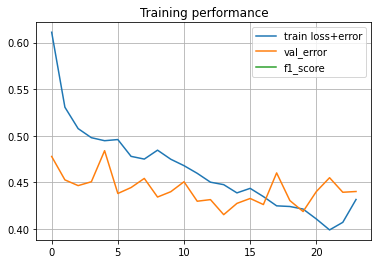

In [ ]:
p = np.array(model5.predict(train_coronal))
train_ACL_pred.append(p)
p = np.array(model5.predict(test_coronal, verbose=1))
test_ACL_pred.append(p)                     
score5 = model5.evaluate(test_coronal ,testACL_labels,verbose=1)       
print('Test loss:',score5[0])
print('Test accuracy:',score5[1])                                                               
plt.figure()
plt.grid()                                                                                                        
plt.title('Training performance')                          
plt.plot(history5.epoch, history5.history['loss'], label='train loss+error')  
plt.plot(history5.epoch, history5.history['val_loss'], label='val_error') 
plt.plot(history5.epoch, history5.history['f1_score'], label='f1_score') 
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel5.h5'
model5.save(filename)
print('>Saved %s' % filename)
clean_up(model=model5)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel5.h5
...Finished clean up...


#### Finetuning ResNet50 Model for Coronal Plane Scanes checking for Abnormal Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Co_Ab = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_Co_Ab.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model6 = Model(inputs=base_model_Co_Ab.input,outputs=predictions)

In [ ]:
for layer in model6.layers[:15]:
   layer.trainable = True
for layer in model6.layers[15:]:
  layer.trainable = False

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model6.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history6=model6.fit(train_coronal ,trainAb_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 48s 867ms/step - loss: 0.7002 - accuracy: 0.6309 - f1_score: nan - val_loss: 0.6740 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 46s 859ms/step - loss: 0.6505 - accuracy: 0.6384 - f1_score: nan - val_loss: 0.6678 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 46s 859ms/step - loss: 0.6413 - accuracy: 0.6319 - f1_score: nan - val_loss: 0.6501 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 46s 857ms/step - loss: 0.6420 - accuracy: 0.6449 - f1_score: nan - val_loss: 0.6492 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 46s 850ms/step - loss: 0.6135 - accuracy: 0.6486 - f1_score: nan - val_loss: 0.6433 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 46s 850ms/step - loss: 0.6111 - accuracy: 0.6449 - f1_score

4/4 [==============================] - 1s 358ms/step - loss: 0.8803 - accuracy: 0.6250 - f1_score: 0.6324
Test loss: 0.8803246021270752
Test accuracy: 0.625


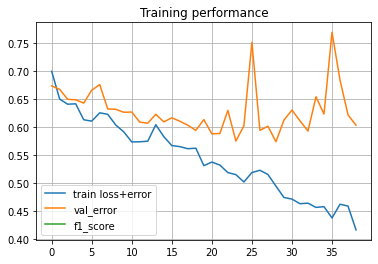

In [ ]:
p = np.array(model6.predict(train_coronal))
train_Ab_pred.append(p)
p = np.array(model6.predict(test_coronal))
test_Ab_pred.append(p)              
score6 = model6.evaluate(test_coronal ,testAb_labels,verbose=1)       
print('Test loss:',score6[0])
print('Test accuracy:',score6[1])                                                          
plt.figure()
plt.grid()                                                                                                          
plt.title('Training performance')                          
plt.plot(history6.epoch, history6.history['loss'], label='train loss+error')  
plt.plot(history6.epoch, history6.history['val_loss'], label='val_error')   
plt.plot(history6.epoch, history6.history['f1_score'], label='f1_score')   
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel6.h5'
model6.save(filename)
print('>Saved %s' % filename)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel6.h5


In [ ]:
clean_up(model=model6)

...Finished clean up...


In [ ]:
del train_coronal
del test_coronal
del coronal_dir
del coronal_reloaded
del coronalTest_reloaded
del coronal_list
del coronalTest_list
del model4
del model5
del model6
del base_model_Co_Men
del base_model_Co_ACL
del base_model_Co_Ab
del p

##Sagittal Planes Scans

###Reading train & test data

In [ ]:
sagittal_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/train/sagittal/")
sagittal_dir = [f.lower() for f in sagittal_dir]   
c=sorted(sagittal_dir)
sagittal_list=np.array(c)
sagittal_reloaded=[]
print(sagittal_list.shape)
for j in range(1,1131):
    file2= "/content/drive/MyDrive/Medical/MRNet-v1.0/train/sagittal/"+sagittal_list[j]
    sagittal_reloaded.append(np.load(file2,allow_pickle='false'))
sagittal_reloaded=np.array(sagittal_reloaded)
print(sagittal_reloaded.shape)
train_sagittal=[]
 
for j in range(len(sagittal_reloaded)):
    mid2=math.floor((sagittal_reloaded[j].shape[0])/2)
    train_sagittal.append([])
       
    for n in range(mid2-1,mid2+2):
         train_sagittal[j].append(sagittal_reloaded[j][n])

train_sagittal=np.array(train_sagittal)
train_sagittal=np.reshape(train_sagittal,(1130,256,256,3))
print(train_sagittal.shape)
sagittal_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/valid/sagittal/")
sagittal_dir = [f.lower() for f in sagittal_dir]   
c=sorted(sagittal_dir)
sagittalTest_list=np.array(c)
sagittalTest_reloaded=[]
print(sagittalTest_list.shape)
for j in range(0,120):
    file2= "/content/drive/MyDrive/Medical/MRNet-v1.0/valid/sagittal/"+sagittalTest_list[j]
    sagittalTest_reloaded.append(np.load(file2,allow_pickle='false'))

sagittalTest_reloaded=np.array(sagittalTest_reloaded)
print(sagittalTest_reloaded.shape)
test_sagittal=[]
 
for j in range(len(sagittalTest_reloaded)):
    mid2=math.floor((sagittalTest_reloaded[j].shape[0])/2)
    test_sagittal.append([])
       
    for n in range(mid2-1,mid2+2):
         test_sagittal[j].append(sagittalTest_reloaded[j][n])

test_sagittal=np.array(test_sagittal)
test_sagittal=np.reshape(test_sagittal,(120,256,256,3))
print(test_sagittal.shape)

(1131,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


(1130,)
(1130, 256, 256, 3)
(120,)
(120,)
(120, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Also reading axial scans for future use

In [ ]:
axial_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/train/axial/")
axial_dir = [f.lower() for f in axial_dir]   
a=sorted(axial_dir)
axial_list=np.array(a)
axial_reloaded=[]
print(axial_list.shape)
for j in range(1,1131):
    file= "/content/drive/MyDrive/Medical/MRNet-v1.0/train/axial/"+axial_list[j]    
    axial_reloaded.append(np.load(file,allow_pickle='false'))   

axial_reloaded=np.array(axial_reloaded)
print(axial_reloaded.shape)
s=axial_reloaded.shape
print(axial_reloaded[0].shape[0])
train_axial=[]
print(len(axial_reloaded))
for j in range(len(axial_reloaded)):
    mid=math.floor((axial_reloaded[j].shape[0])/2)
    train_axial.append([])    

    for n in range(mid-1,mid+2):
         train_axial[j].append(axial_reloaded[j][n])
train_axial=np.array(train_axial)
train_axial=np.reshape(train_axial,(1130,256,256,3))
print(train_axial.shape)
axial_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/valid/axial/")
axial_dir = [f.lower() for f in axial_dir]   
a=sorted(axial_dir)
axialTest_list=np.array(a)
axialTest_reloaded=[]

print(axialTest_list.shape)

for j in range(0,120):
    file= "/content/drive/MyDrive/Medical/MRNet-v1.0/valid/axial/"+axialTest_list[j]
    axialTest_reloaded.append(np.load(file,allow_pickle='false'))   

axialTest_reloaded=np.array(axialTest_reloaded)
print(axialTest_reloaded.shape)
s=axialTest_reloaded.shape
print(axialTest_reloaded[0].shape[0])
test_axial=[]
print(len(axialTest_reloaded))
for j in range(len(axialTest_reloaded)):
    mid=math.floor((axialTest_reloaded[j].shape[0])/2)
    test_axial.append([])    

    for n in range(mid-1,mid+2):
         test_axial[j].append(axialTest_reloaded[j][n])
test_axial=np.array(test_axial)
test_axial=np.reshape(test_axial,(120,256,256,3))
print(test_axial.shape)

(1131,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


(1130,)
44
1130
(1130, 256, 256, 3)
(120,)
(120,)
25
120
(120, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### Finetuning ResNet50 Model for Sagittal Plane Scanes checking for Mensical Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Sa_Men = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
x = base_model_Sa_Men.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model7 = Model(inputs=base_model_Sa_Men.input,outputs=predictions)

In [ ]:
for layer in model7.layers[:15]:
   layer.trainable = True
for layer in model7.layers[15:]:
   layer.trainable = True

In [ ]:
trainMen_labels = np.array(trainMen_labels)

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model7.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history7=model7.fit(train_sagittal ,trainMen_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
54/54 [==============================] - 49s 872ms/step - loss: 0.8814 - accuracy: 0.6253 - f1_score: nan - val_loss: 0.6869 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 45s 842ms/step - loss: 0.6757 - accuracy: 0.6505 - f1_score: nan - val_loss: 0.6755 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 45s 841ms/step - loss: 0.6629 - accuracy: 0.6505 - f1_score: nan - val_loss: 0.6697 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 45s 840ms/step - loss: 0.6555 - accuracy: 0.6505 - f1_score: nan - val_loss: 0.6675 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 45s 839ms/step - loss: 0.6514 - accuracy: 0.6505 - f1_score: nan - val_loss: 0.6669 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 45s 840ms/step - loss: 0.6500 - accuracy: 0.650

4/4 [==============================] - 1s 356ms/step - loss: 0.6987 - accuracy: 0.5667 - f1_score: nan
Test loss: 0.6986700892448425
Test accuracy: 0.5666666626930237


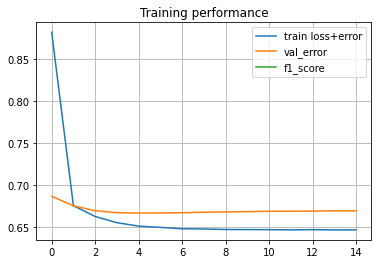

In [ ]:
p = np.array(model7.predict(train_sagittal))
train_Men_pred.append(p)
p = np.array(model7.predict(test_sagittal))
test_Men_pred.append(p)            
score7 = model7.evaluate(test_sagittal ,testMen_labels,verbose=1)       
print('Test loss:',score7[0])
print('Test accuracy:',score7[1])                                                         
plt.figure()
plt.grid()                                                                                                
plt.title('Training performance')                          
plt.plot(history7.epoch, history7.history['loss'], label='train loss+error')  
plt.plot(history7.epoch, history7.history['val_loss'], label='val_error')
plt.plot(history7.epoch, history7.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel7.h5'
model7.save(filename)
print('>Saved %s' % filename)
clean_up(model=model7)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel7.h5
...Finished clean up...


#### Finetuning ResNet50 Model for Sagittal Plane Scanes checking for ACL Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Sa_ACL = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_Sa_ACL.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model8 = Model(inputs=base_model_Sa_ACL.input,outputs=predictions)

In [ ]:
for layer in model8.layers[:15]:
   layer.trainable = True
for layer in model8.layers[15:]:
   layer.trainable = True

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)
model8.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history8=model8.fit(train_sagittal ,trainACL_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 49s 877ms/step - loss: 0.7382 - accuracy: 0.7512 - f1_score: nan - val_loss: 0.4712 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 47s 868ms/step - loss: 0.5241 - accuracy: 0.8108 - f1_score: nan - val_loss: 0.4668 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 47s 868ms/step - loss: 0.5167 - accuracy: 0.8145 - f1_score: nan - val_loss: 0.4254 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 47s 869ms/step - loss: 0.5186 - accuracy: 0.8145 - f1_score: nan - val_loss: 0.4406 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 47s 870ms/step - loss: 0.5028 - accuracy: 0.8145 - f1_score: nan - val_loss: 0.4417 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 47s 870ms/step - loss: 0.4797 - accuracy: 0.8145 - f1_score

4/4 [==============================] - 1s 361ms/step - loss: 0.7610 - accuracy: 0.5500 - f1_score: nan
Test loss: 0.7609687447547913
Test accuracy: 0.550000011920929


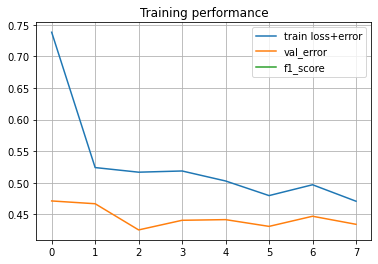

In [ ]:
p = np.array(model8.predict(train_sagittal))
train_ACL_pred.append(p)
p = np.array(model8.predict(test_sagittal))
test_ACL_pred.append(p)                       
score8 = model8.evaluate(test_sagittal ,testACL_labels,verbose=1)       
print('Test loss:',score8[0])
print('Test accuracy:',score8[1])                                                                   
plt.figure()
plt.grid()                                                                                                         
plt.title('Training performance')                          
plt.plot(history8.epoch, history8.history['loss'], label='train loss+error')  
plt.plot(history8.epoch, history8.history['val_loss'], label='val_error')
plt.plot(history8.epoch, history8.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel8.h5'
model8.save(filename)
print('>Saved %s' % filename)
clean_up(model=model8)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel8.h5
...Finished clean up...


#### Finetuning ResNet50 Model for Sagittal Plane Scanes checking for Abnormal Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Sa_Ab = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_Sa_Ab.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model9 = Model(inputs=base_model_Sa_Ab.input,outputs=predictions)

In [ ]:
for layer in model9.layers[:15]:
   layer.trainable = True
for layer in model9.layers[15:]:
   layer.trainable = True

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model9.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history9=model9.fit(train_sagittal ,trainAb_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
54/54 [==============================] - 85s 1s/step - loss: 1.0111 - accuracy: 0.5974 - f1_score: nan - val_loss: 0.6822 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 55s 1s/step - loss: 0.6714 - accuracy: 0.6505 - f1_score: nan - val_loss: 0.6741 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 55s 1s/step - loss: 0.6612 - accuracy: 0.6505 - f1_score: nan - val_loss: 0.6692 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 55s 1s/step - loss: 0.6554 - accuracy: 0.6505 - f1_score: nan - val_loss: 0.6675 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 55s 1s/step - loss: 0.6523 - accuracy: 0.6505 - f1_score: nan - val_loss: 0.6670 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 55s 1s/step - loss: 0.6497 - accuracy: 0.6505 - f1_score: nan 

4/4 [==============================] - 2s 422ms/step - loss: 0.9162 - accuracy: 0.2083 - f1_score: nan
Test loss: 0.9161697626113892
Test accuracy: 0.2083333283662796


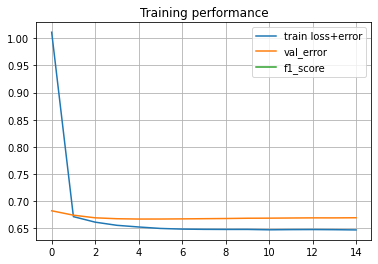

In [ ]:
p = np.array(model9.predict(train_sagittal))
train_Ab_pred.append(p)
p = np.array(model9.predict(test_sagittal))
test_Ab_pred.append(p)                       
score9 = model9.evaluate(test_sagittal ,testAb_labels,verbose=1)       
print('Test loss:',score9[0])
print('Test accuracy:',score9[1])                                                                   
plt.figure()
plt.grid()                                                                                                       
plt.title('Training performance')                          
plt.plot(history9.epoch, history9.history['loss'], label='train loss+error')  
plt.plot(history9.epoch, history9.history['val_loss'], label='val_error')
plt.plot(history9.epoch, history9.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/VGGmodel9.h5'
model9.save(filename)
print('>Saved %s' % filename)
clean_up(model=model9)

In [ ]:
del train_sagittal
del test_sagittal
del sagittal_dir
del sagittal_reloaded
del sagittalTest_reloaded
del sagittal_list
del sagittalTest_list
del model7
del model8
del model9
del base_model_Sa_Men
del base_model_Sa_ACL
del base_model_Sa_Ab
del p

##Ensembling

---
We ensemble the models for each state detection for three planes Axial,Coronal and Sagittal respectively and train a Sequential model with input being probabitity of condition detection by indiviual model and output again being probability person has the condition. We give original label for evaluation of the method.

`We couldnt run this for VGG16 as we ran out of Memory/RAM in colab but this worked with other baselines models like ResNet50`

#### Meniscal Condition Detection

In [ ]:
train_Men_pred = np.array(train_Men_pred)
print(train_Men_pred.shape)
test_Men_pred = np.array(test_Men_pred)
print(test_Men_pred.shape)
train_Men_pred = train_Men_pred.reshape((1130,3))
test_Men_pred = test_Men_pred.reshape((120,3))
print(train_Men_pred)

In [ ]:
menModel = Sequential()
menModel.add(Dense(1, activation='sigmoid', input_dim=3))
menModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_score])
h = menModel.fit(train_Men_pred, trainMen_labels, batch_size=32, epochs=50, verbose=1)

In [ ]:
loss, acc, f1 = menModel.evaluate(test_Men_pred, testMen_labels)
p1 = menModel.predict(test_Men_pred)
print("Loss: ", loss)
print('Accuracy: ', acc)                                                  
plt.figure()
plt.grid()                                                           
plt.title('Testing performance')                          
plt.plot(h.epoch, h.history['loss'], label='train loss+error')  
plt.plot(h.epoch, h.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
del train_Men_pred
del menModel

#### ACL Condition Detection

In [ ]:
train_ACL_pred = np.array(train_ACL_pred)
print(train_ACL_pred.shape)
test_ACL_pred = np.array(test_ACL_pred)
print(test_Men_pred.shape)
train_ACL_pred = train_ACL_pred.reshape((1130,3))
test_ACL_pred = test_ACL_pred.reshape((120,3))
print(test_ACL_pred)

In [ ]:
menModel = Sequential()
menModel.add(Dense(1, activation='sigmoid', input_dim=3))
menModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_score])
h = menModel.fit(train_ACL_pred, trainACL_labels, batch_size=32, epochs=50, verbose=1)

In [ ]:
loss, acc, f1 = menModel.evaluate(test_ACL_pred, testACL_labels)
p2 = menModel.predict(test_ACL_pred)
print("Loss: ", loss)
print('Accuracy: ', acc)                                
plt.figure()
plt.grid()                                                                                                       
plt.title('Testing performance')                          
plt.plot(h.epoch, h.history['loss'], label='train loss+error')  
plt.plot(h.epoch, h.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
del train_ACL_pred
del menModel

#### Abnormal Condition Detection

In [ ]:
np.isnan(np.sum(trainAb_labels))

In [ ]:
train_Ab_pred = np.array(train_Ab_pred)
print(train_Ab_pred.shape)
test_Ab_pred = np.array(test_Ab_pred)
print(test_Ab_pred.shape)
train_Ab_pred = train_Ab_pred.reshape((1130,3))
test_Ab_pred = test_Ab_pred.reshape((120,3))
print(test_ACL_pred)

In [ ]:
abModel = Sequential()
abModel.add(Dense(1, activation='sigmoid', input_dim=3))
abModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_score] )
h = abModel.fit(train_Ab_pred, trainAb_labels, batch_size=32, epochs=50, verbose=1)

In [ ]:
loss, acc, f1 = abModel.evaluate(test_Ab_pred, testAb_labels)
p3 = abModel.predict(test_Ab_pred)
print("Loss: ", loss)
print('Accuracy: ', acc)                                  
plt.figure()
plt.grid()                                                                                                       
plt.title('Testing performance')                          
plt.plot(h.epoch, h.history['loss'], label='train loss+error')  
plt.plot(h.epoch, h.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
del train_Ab_pred
del abModel